In [407]:
# reload magics
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## IMPORTS

In [408]:
import colorcet as cc
import logging
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from hdbscan import all_points_membership_vectors, HDBSCAN
from umap import UMAP

from copy import deepcopy, copy

from upsetplot import from_memberships, plot, UpSet, from_indicators

from typing import Dict, List, Tuple, Optional

palette = cc.glasbey_hv

# create a palette dictionary that has the same keys as the original palette
palette_dict = {i: mc.to_hex(palette[i]) for i in range(len(palette))} # type: ignore

# add an entry for -1
palette_dict[-1] = '#ffffff'

# set default colour for seaborn heatmaps
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(8,8)}, palette='viridis')


In [409]:
# heatmap parms
heatmap_parms = {
                'cbar': False,
                'square': False,
                'linewidths': 0.5,
                'linecolor': 'black',
                'center': 0.0,
                'vmin': -1,
                'vmax': 1,
                # 'annot': False,
                'fmt': '.2f',
}

# from the data dictionary
site_name_dict = {
                  1: 'LDN',
                  2: 'MTL',
                  3: 'SAN',
                  4: 'RIO',
                  5: 'LUS',
}

# assign consistent styles
site_style = {
              1: 'D',
              2: 'o',
              3: 'P',
              4: 'X',
              5: 's',
}

In [410]:
figdir   = "./OUTPUT/lc-pos-figures"
data_dir = "../lc-project-data"

## FUNCTIONS

In [411]:
#===============================================================================
def compare_two_clusters(df, a, b):
#===============================================================================
# a function to compare two clusters - returns the concatenated cluster data for further analysis

    subset_a = df.query(f"cluster == {a}")
    subset_b = df.query(f"cluster == {b}")

    index_a = subset_a.index
    index_b = subset_b.index

    df_a = df.loc[index_a]
    df_b = df.loc[index_b]

    # concatenate
    df_ab = pd.concat([df_a, df_b])

    # cast cluster to int
    df_ab["cluster"] = df_ab["cluster"].astype(int)

    return df_ab


In [412]:
#===============================================================================
def make_centroids(e, lbls):
#===============================================================================

    # assume that lbls is a pandas series
    if isinstance(lbls, pd.Series):
        lbls = lbls.values
    


    # get the centroids of the umap coordinates by cluster
    centroids = pd.DataFrame(e, 
                                columns = ["x", "y"]).assign(cluster = lbls).groupby("cluster").mean()
    return centroids


#===============================================================================
def make_plot_df(embeddings, clusterer, index, sites):
#===============================================================================

    d = pd.DataFrame(embeddings, columns = ["x", "y"], index = index)
    d["Cluster"]             = clusterer.labels_
    d["Cluster Confidence"]  = clusterer.probabilities_


    try:
        d["Most Likely Cluster"] = np.argmax(all_points_membership_vectors(clusterer), axis = 1)
    except (KeyError, AttributeError):
        d["Most Likely Cluster"] = clusterer.labels_


    # EXPT

    d["Site"]                = sites


    return d



In [413]:
#===============================================================================
def plot_clusters(
                    df: pd.DataFrame, 
                    site_name_dict: dict,
                    centroids: Optional[pd.DataFrame] = None, 
                    title: Optional[str] = None,
                      most_likely: bool = False
                      ):
#===============================================================================

    # plot the embeddings
    fig, ax = plt.subplots(figsize=(10, 10))

    if most_likely:
        hue = "Most Likely Cluster"
    else:
        hue = "Cluster"

    sns.scatterplot(data = df, 
                    x = "x",
                    y = "y",
                    s = 50,
                    edgecolor = 'black', 
                    hue       = hue,
                    linewidth = 0.5, 
                    palette   = palette_dict,
                    style     = "Site",
                    style_order = site_name_dict.values(),
                    markers = ['o','D', 'P', 'X', 's'],
                    size      = "Cluster Confidence",
                    ax = ax
                        )

    if centroids is not None:
        # plot centroids
        plot_centroids(centroids, ax)

    # set title
    if title:
        plt.title(title)

    # place the legend outside to the right of the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    # turn off axis labels and ticks
    plt.xticks([]); plt.yticks([]);
    plt.xlabel(""); plt.ylabel("");


#===============================================================================
def plot_centroids(centroids, ax):
#===============================================================================
    # plot the centroids
    for i, centroid in centroids.iterrows():
        if i != -1:

            ax.annotate(
                        i,
                        (centroid.x, centroid.y), 
                        ha='center',
                        va='center',
                        bbox=dict(boxstyle="round,pad=0.3", 
                                    fc="white", 
                                    ec="black",
                                    lw=1, 
                                    # alpha=0.75
                                    )
                        )



In [414]:
#===============================================================================
def make_upset_data(df, 
                    ftrs, 
                    method = "mean", 
                    add_column = None,
                    keep_features = False):
#===============================================================================

    if method not in ["mean", "median"]:
        print(f"Method {method} not supported.")

    else:
        if method == "mean":
            new_df = df[ftrs] > df[ftrs].mean(axis = 0)
        # elif method == "median":
        else:
            new_df = df[ftrs] > df[ftrs].median(axis = 0)

    new_df = new_df[ftrs]
    new_df.rename(columns= {c: f">{c}" for c in ftrs}, inplace = True)

    df2 = pd.concat([df, new_df, add_column], axis = 1) # type: ignore
    if keep_features == True:
        pass
    else:
        df2 = df2.set_index(list(new_df.columns))

    return df2

In [415]:
#===============================================================================
def excursion_plot(d, 
                    method = "mean",
                    grouper = "cluster",
                    style: str = "binary",
                    figsize = (6,48),
                    ):
#===============================================================================

    norm = None

    # find all object columns and drop them
    d = d.select_dtypes(exclude = "object")


    # get the global median for each feature
    global_median = d.median()
    global_mean   = d.mean()

    globals = pd.concat([global_median, global_mean], axis = 1)
    globals.columns = ["Ensemble Median", "Ensemble Mean"]

    globals.drop(grouper, inplace = True)


    # per feature mean and median
    mm_mean   = d.groupby(grouper).mean().T
    mm_median = d.groupby(grouper).median().T

    # which version?
    if method == "mean":
        mm = mm_mean
        selector = "Ensemble Mean"
    elif method == "median":
        mm = mm_median
        selector = "Ensemble Median"
    else:
        print(f"Method {method} not supported.")
        

    if style == "cont":
        # do the basic plot of means or medians
        # colourmap
        cmap = cc.cm.bjy
        fig, ax = plt.subplots(figsize=figsize)

        # heatmsp
        sns.heatmap(mm, 
                        cmap = cmap, 
                        ax   = ax, 
                        **heatmap_parms, 
                        norm = norm, 
                        annot = True
                        )

        plt.title(f"Cluster Plot")
        plt.yticks(fontsize = 8);

    else:
        # mm is the mean or median per cluster per feature
        qq = pd.DataFrame(index = mm.index, columns = mm.columns)

        # for each cluster c in mm, 
        for c in mm.columns:
            # for each feature in this cluster, compare to the respective global mean
            for i, v in enumerate(mm[c].values):
                # is this cluster's mean or median greater than 
                # the global ensemble mean or median?
                # this will fill qq with true/false
                qq.loc[qq.index[i],c] = v >  globals.loc[qq.index[i], selector] # type: ignore

        # qq.astype(int)
        fig, ax = plt.subplots(figsize=figsize)

        sns.heatmap(qq.astype(int), 
                    cmap = cc.bjy, 
                    ax = ax, 
                    cbar = False, 
                    vmin = -1, 
                    linewidth = 0.5, 
                    square = False, 
                    linecolor = 'k'
                    )

        plt.yticks(fontsize = 8);
        plt.title(f"Excursion Plot: {str.title(grouper)} {str.title(method)} > {selector}")

    # return globals, qq

In [416]:
#===============================================================================
def plot_cluster_by_site(src,
                         data,
                         labels,
                         title: str,
                         tag: str,
                         ):
#===============================================================================

    # make a copy of the source data
    site_g = src.copy()

    # augment with cluster labels
    site_g.loc[data.index, "cluster"] = labels["Cluster"]

    # group and count
    cluster_by_site = site_g.groupby("cluster")["SITE"].value_counts().unstack().T

    # fill missing values
    cluster_by_site = cluster_by_site.fillna(0).astype(int)

    # rename columns
    cluster_by_site.columns = cluster_by_site.columns.astype(int)
    # cluster_by_site = cluster_by_site.loc[site_name_dict.values()]

    # sort index alphabetically
    

    fig, ax = plt.subplots(figsize=(8,8), layout = "constrained")

    sns.heatmap(cluster_by_site, 
                robust     = True, 
                ax         = ax, 
                annot      = True, 
                fmt        = "d", 
                cmap       = "viridis", 
                square     = True, 
                linewidths = 0.5, 
                linecolor  = "w", 
                cbar       = False)

    # rename axis labels
    plt.xlabel("Cluster")
    plt.ylabel("Site")
    plt.title(title)

    # fn = f"cluster-membership-umap-{tag}.png"
    # p = f"{figdir}/{fn}"

    # plt.savefig(p, dpi = 300, bbox_inches = 'tight')


## LOAD DATA

In [417]:
# load the data from the xlsx file
# df = pd.read_excel('../lc-project-data/features.xlsx')

In [418]:
# datasets are way faster than excel files
from datasets.arrow_dataset import Dataset

# load the dataset from disk
ds_all = Dataset.load_from_disk('../lc-project-data/features.arrow')
ds     = Dataset.load_from_disk('../lc-project-data/features.arrow')

In [419]:
df_all = ds_all.data.to_pandas()
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Columns: 421 entries, sex to LC_STATUS
dtypes: float64(366), int64(54), object(1)
memory usage: 18.2+ MB


In [420]:
# convert to pandas dataframe
df = ds.to_pandas()
df.info() # type: ignore

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Columns: 421 entries, sex to LC_STATUS
dtypes: float64(366), int64(54), object(1)
memory usage: 18.2+ MB


## LC+, LC-, HC

### Select which sets of feaetures to use

In [421]:
tag = 'all'

print(df.shape) # type: ignore

(5664, 421)


In [422]:
LC_pos = df.query('LC_STATUS == "LC_POS"').copy() # type: ignore
LC_neg = df.query('LC_STATUS == "LC_NEG"').copy() # type: ignore 
HC     = df.query('LC_STATUS == "HC"').copy()     # type: ignore

In [423]:
LC_pos.shape, LC_neg.shape, HC.shape

((2215, 421), (3367, 421), (82, 421))

In [424]:
# drop object columns because we don't need this 
try:
    LC_pos = LC_pos.drop(columns=['LC_STATUS'])
except:
    pass


In [425]:
LC_pos

,sex,age,dag,MED-Analgesics,MED-Anesthetics,MED-Antibacterials,MED-Anticonvulsants,MED-Antidepressants,MED-Antifungals,MED-Antimigraine-agents,...,CD-type_of_care___2,CD-ventilatory_support_type___1,CD-ventilatory_support_type___2,CD-ventilatory_support_type___3,CD-ventilatory_support_type___4,CD-ventricular_tachycardia_or___1,CD-ventricular_tachycardia_or___2,CD-ventricular_tachycardia_or___3,CD-ventricular_tachycardia_or___4,CD-weight_kgs
0,2.0,30.0,2,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,1.0,33.0,2,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.00
2,2.0,36.0,2,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.00
3,2.0,50.0,2,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.00
4,1.0,40.0,2,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,136.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5659,1.0,48.0,3,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93.38
5660,2.0,42.0,3,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,125.79
5661,1.0,23.0,3,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.24
5662,1.0,71.0,3,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,136.53


In [426]:
# how many missing values per dag?
print("Missing VAX values by site:")
LC_pos.groupby('dag').apply(lambda x: x.isnull().sum()).rename(index = site_name_dict)["VAX-vaccinated"]

Missing VAX values by site:


/var/folders/sb/yk61ysxx3bq0fh_vt074lv6w0000gn/T/ipykernel_62323/1693233030.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  LC_pos.groupby('dag').apply(lambda x: x.isnull().sum()).rename(index = site_name_dict)["VAX-vaccinated"]


dag
LDN      9
MTL      6
SAN      0
RIO      0
LUS    186
Name: VAX-vaccinated, dtype: int64

In [427]:
# drop rows where VAX-vaccinated is nan
LC_pos = LC_pos.dropna(subset = ["VAX-vaccinated"])

print(LC_pos.shape)

(2014, 420)


## SITES

In [428]:
# # from the data dictionary
# site_name_dict = {
#                   1: 'LDN',
#                   2: 'MTL',
#                   3: 'SAN',
#                   4: 'RIO',
#                   5: 'LUS',
# }

# # assign consistent styles
# site_style = {
#               1: 'D',
#               2: 'o',
#               3: 'P',
#               4: 'X',
#               5: 's',
# }

In [429]:
# # sort by dag
# LC_pos = LC_pos.sort_values(by='dag')


In [430]:
# map dag using site_name_dict
LC_pos.loc[LC_pos.index, 'SITE'] = LC_pos.loc[LC_pos.index, 'dag'].map(site_name_dict)

/var/folders/sb/yk61ysxx3bq0fh_vt074lv6w0000gn/T/ipykernel_62323/2981456874.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LC_pos.loc[LC_pos.index, 'SITE'] = LC_pos.loc[LC_pos.index, 'dag'].map(site_name_dict)


In [431]:
# get the range of indices for each site
site_ranges = LC_pos.groupby('SITE').apply(lambda x: (x.index.min(), x.index.max())).rename(index = site_name_dict) # type: ignore

site_ranges
# site_ranges.sort_values()

/var/folders/sb/yk61ysxx3bq0fh_vt074lv6w0000gn/T/ipykernel_62323/3559136858.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  site_ranges = LC_pos.groupby('SITE').apply(lambda x: (x.index.min(), x.index.max())).rename(index = site_name_dict) # type: ignore


SITE
LDN    (5473, 5590)
LUS    (3728, 5620)
MTL       (0, 1764)
RIO    (2913, 3563)
SAN    (4969, 5663)
dtype: object

### Drop Sites

In [432]:
# drop RIO and LUS
# LC_pos = LC_pos.query('SITE != "RIO" and SITE != "LUS"')
# LC_pos = LC_pos.query('SITE != "LUS"')
LC_pos['SITE'].value_counts()

SITE
MTL    910
RIO    651
SAN    266
LDN    101
LUS     86
Name: count, dtype: int64

In [433]:
# get the range of indices for each site
site_ranges = LC_pos.groupby('SITE').apply(lambda x: (x.index.min(), x.index.max())).rename(index = site_name_dict) # type: ignore

site_ranges.sort_values()

/var/folders/sb/yk61ysxx3bq0fh_vt074lv6w0000gn/T/ipykernel_62323/1024437399.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  site_ranges = LC_pos.groupby('SITE').apply(lambda x: (x.index.min(), x.index.max())).rename(index = site_name_dict) # type: ignore


SITE
MTL       (0, 1764)
RIO    (2913, 3563)
LUS    (3728, 5620)
SAN    (4969, 5663)
LDN    (5473, 5590)
dtype: object

# CLUSTERING

In [434]:
# clustering
from sklearn.preprocessing import MinMaxScaler

# dim reduction and clustering benefit from scaling
scaler = MinMaxScaler().set_output(transform = "pandas")

### Which features to drop, if any

In [435]:
# a new dataframe, in case we need to manipulate it and retain the original
LC_pos_ = LC_pos

# drop certain columns, to experiment with effect on clustering
# # based on experiments, MED and CD do almost nothing for clustering, so we drop them
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'LABS').columns)
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'MED').columns)
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'SYMPT').columns)

print(LC_pos_.shape)

(2014, 359)


In [436]:
# drop columns that are all zero
LC_pos_ = LC_pos_.loc[:, (LC_pos_ != 0).any(axis=0)]
print(LC_pos_.shape)
# heatmap of missing values
# sns.heatmap(LC_pos_.isnull().T, cbar=False,)

(2014, 356)


In [437]:
# # plot haemoglobin by site
# fig, ax = plt.subplots(figsize=(6,6))

# sns.boxplot(data = LC_pos_, x = LC_pos_["dag"].map(site_name_dict), y = "LABS-haemoglobin", ax = ax, )

In [438]:
# drop the dag and SITE columns - these might guide the clustering algorithm to cluster by site

try:
    LC_pos_ = LC_pos_.drop(columns=['LC_STATUS'])
except:
    pass

X = scaler.fit_transform(LC_pos_.drop(columns=['dag', 'SITE']))     # type: ignore


## Use UMAP to visualize the data and cluster

In [439]:
from hdbscan import HDBSCAN, approximate_predict, all_points_membership_vectors
from umap import UMAP

hdb_parms = {
                # min_cluster_size is rouglhy 
                # sqrt(n) where n is the number of samples
                'min_cluster_size': 50, 
                # 'min_samples': 50,
                'prediction_data': True,
                'cluster_selection_method': 'leaf',
                'cluster_selection_epsilon': 0.1,
            }


umap_parms = {
                'n_components': 2,
                'spread':       5.0,
                'random_state': 42,
            }


# instantiate the clustering and dim reduction objects
hdb_umap   = HDBSCAN(**hdb_parms)
umap_      = UMAP(**umap_parms)

In [440]:
# umap_options = {
#     'fill_na': X.fillna(0),
#     # 'drop_na': X.dropna(how = "all"),
#     # 'ignore_na': X,
# }
# for k,v in umap_options.items():
#     print(v.shape)
#     print(f"Number of nans: {v.isna().sum().sum()}")
#     # try:
#     #     umap_.fit(v)
#     # except:
#     #     pass
# for k,v in umap_options.items():

#     print(f"Case: {k}: {v.shape}; number of nans: {v.isna().sum().sum()}")

#     X = v
#     X_ref = deepcopy(X)

#     if k == 'ignore_na':
#         UMAP_FORCE_ALL_FINITE = False
#     else:
#         UMAP_FORCE_ALL_FINITE = True

#     UMAP_FORCE_ALL_FINITE = False

#     try:
#         # dimension reduction
#         umap_embeddings = umap_.fit_transform(X, 
#                                             force_all_finite = UMAP_FORCE_ALL_FINITE
#                                                 )

#         # clustering on the reduced data
#         hdb_umap.fit(umap_embeddings)
#         # get the cluster vectors
#         cvec = all_points_membership_vectors(hdb_umap)
#         # cluster labels are the maximally probable cluster
#         cluster_labels = np.argmax(cvec, axis = 1)

#         print(f"Found {len(np.unique(cluster_labels))} clusters")

#         # # make a plotting dataframe
#         sites = LC_pos_["dag"].map(site_name_dict)
#         plot_df = make_plot_df(umap_embeddings, hdb_umap, X_ref.index, sites)

#         # get the centroids of the umap coordinates by cluster
#         umap_centroids = make_centroids(umap_embeddings, cluster_labels)

#         plot_clusters(plot_df, site_name_dict, centroids = umap_centroids, title = f"UMAP + HDBSCAN Clustering - {tag} - {k}", most_likely = False)

#         fn = f"clusters-umap-{tag}-{k}.png"
#         p = f"{figdir}/{fn}"

#         plt.savefig(p, dpi = 300, bbox_inches = 'tight')



#     except:
#         pass

### Handling missing values

In [441]:
# the clustering algorithms depend on the data being complete
# if we drop NAs, then there are only 3 records from LUS left
# X = X.dropna(axis = 1)

# if we fill with zeroes, then we are assuming that the missing values are zero
X.fillna(0, inplace = True)

print(X.shape)


(2014, 354)


### EMBED and CLUSTER

In [442]:
# sklearn pipelines
import sklearn.cluster as cluster
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

from hdbscan import HDBSCAN



min_cluster_size = int(np.sqrt(X.shape[0]))

hdb_parms = {
                # min_cluster_size is roughly 
                # sqrt(n) where n is the number of samples
                'min_cluster_size': min_cluster_size, 
                'cluster_selection_method': 'leaf',
                'cluster_selection_epsilon': 0.5,
            }

tsne_transformer = FunctionTransformer(TSNE(n_components = 2, 
                                            random_state = 42, 
                                            verbose = 1).fit_transform, validate=False)

umap_transformer = UMAP(**umap_parms, verbose = True)

embedding_model = umap_transformer
embedding_model = tsne_transformer

# instantiate the pipeline
pipe = Pipeline([
                # scale to unit size
                ('scaler', MinMaxScaler()),
                # for embeddings, we can use TSNE or UMAP
                ('embed', embedding_model),
                # ('embed', tsne_transformer),
                # ('embed', UMAP(**umap_parms, verbose = False)),
                # the sklearn HDBCSAN implementation does not have all the 
                # methods of the hdbscan package, so we need to use the hdbscan package
                # ('cluster', cluster.HDBSCAN(**hdb_parms)),
                ('cluster', HDBSCAN(**hdb_parms, prediction_data = True)),
                ])

# apply to the feature dataframe
pipe.fit(X)

if isinstance(pipe.steps[1][1], UMAP):
    points   = pipe["embed"].embedding_
elif isinstance(pipe.steps[1][1], FunctionTransformer):
    points   = pipe["embed"].transform(X)
else:
    print(f"Something went wrong - {pipe.steps[1][1]}")


clusters = pipe["cluster"].labels_
probs    = pipe["cluster"].probabilities_
sites    = LC_pos_.loc[X.index]["dag"].map(site_name_dict)

# # cluster labels are the maximally probable cluster
cluster_labels = np.argmax(all_points_membership_vectors(pipe["cluster"]), 
                           axis = 1)

clusters = cluster_labels

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2014 samples in 0.001s...
[t-SNE] Computed neighbors for 2014 samples in 0.044s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2014
[t-SNE] Computed conditional probabilities for sample 2000 / 2014
[t-SNE] Computed conditional probabilities for sample 2014 / 2014
[t-SNE] Mean sigma: 0.910691
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.251572
[t-SNE] KL divergence after 1000 iterations: 1.640037
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2014 samples in 0.001s...
[t-SNE] Computed neighbors for 2014 samples in 0.042s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2014
[t-SNE] Computed conditional probabilities for sample 2000 / 2014
[t-SNE] Computed conditional probabilities for sample 2014 / 2014
[t-SNE] Mean sigma: 0.910691
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.251274
[t-SNE] KL divergence after 1000 iterations: 1.645035


In [443]:
plot_df = pd.DataFrame(points, columns = ["x", "y"], index = X.index)
plot_df["Cluster"] = clusters
plot_df["Cluster Confidence"] = probs
plot_df["Site"] = sites

# what fraction of the data is in each cluster?
plot_df["Cluster"].value_counts(normalize = True)*100


Cluster
4    25.074479
3    21.996028
1    20.506455
5    15.441907
0    11.122145
2     5.858987
Name: proportion, dtype: float64

In [444]:
# count cluster members by site
cluster_by_site = plot_df.groupby("Cluster")["Site"].value_counts().unstack().T.fillna(0).astype(int)
# convert to percent of site
# cluster_by_site = cluster_by_site.div(cluster_by_site.sum(axis = 1), axis = 0)*100

cluster_by_site

Cluster,0,1,2,3,4,5
Site,,,,,,
LDN,3,2,24,18,47,7
LUS,1,1,76,5,3,0
MTL,3,51,1,129,423,303
RIO,2,358,6,284,0,1
SAN,215,1,11,7,32,0


In [445]:
plot_df

,x,y,Cluster,Cluster Confidence,Site
0,31.124649,-0.914835,4,1.000000,MTL
1,38.958881,-8.156507,4,0.902503,MTL
2,35.031303,5.807735,4,0.000000,MTL
3,20.841722,-3.222994,4,0.834875,MTL
4,29.570335,-1.913231,4,1.000000,MTL
...,...,...,...,...,...
5659,51.275959,-7.509007,4,0.000000,SAN
5660,53.276333,-8.514155,4,0.000000,SAN
5661,19.477180,9.045752,3,0.000000,SAN
5662,30.997515,10.692109,4,0.000000,SAN


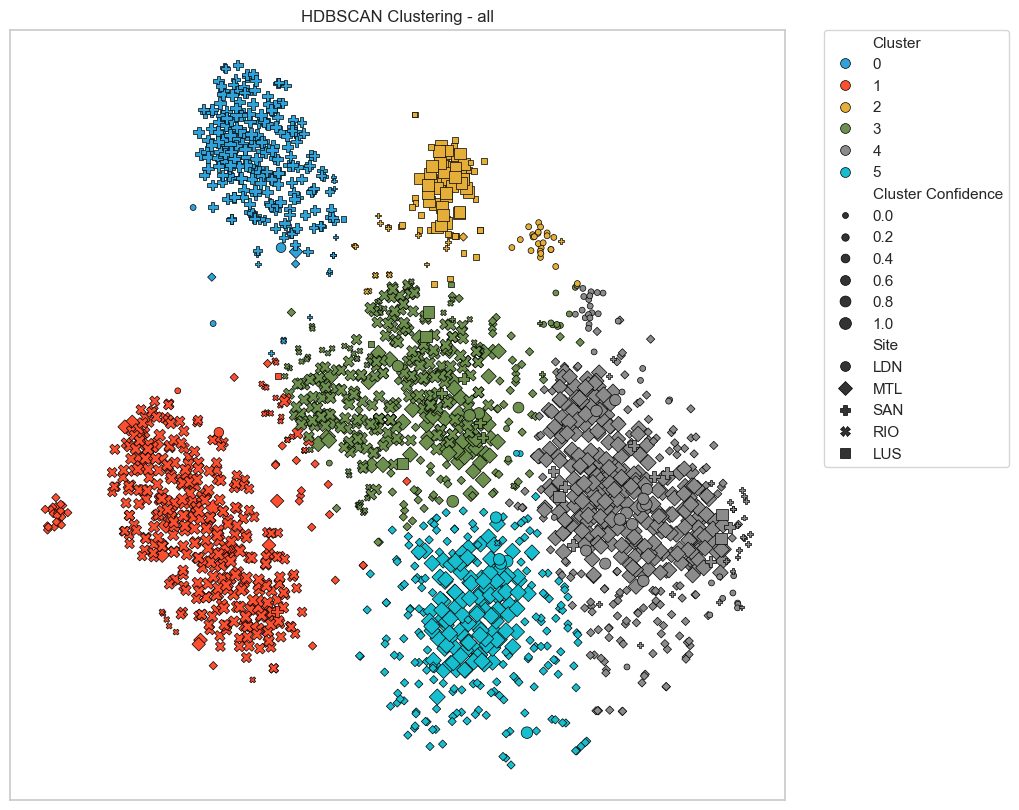

In [446]:
plot_clusters(plot_df, site_name_dict, title = f"HDBSCAN Clustering - {tag}")

### Cluster by Site

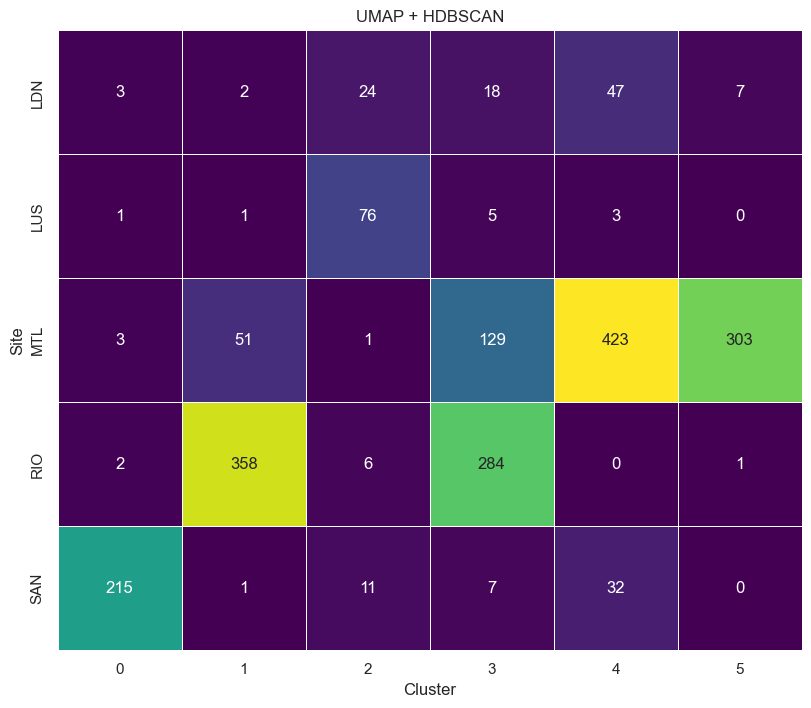

In [447]:
plot_cluster_by_site(LC_pos_, X, plot_df, "UMAP + HDBSCAN", tag)

### Examine some of the clusters

In [448]:
# save the cluster labels to a copy of the original dataframe

A = X.copy()
A["cluster"] = cluster_labels


interesting = [
            #    "VAX-vaccinated", 
                "HHX-HIV or AIDS", 
               "HHX-Diabetes", 
               "HHX-Arterial Hypertension", 
               "HHX-Psychiatric disease", 
               ]


try:
    # get the means by cluster
    print(A.groupby("cluster")[interesting].mean())
except:
    pass


         HHX-HIV or AIDS  HHX-Diabetes  HHX-Arterial Hypertension  \
cluster                                                             
0               0.004464      0.227679                   0.290179   
1               0.002421      0.026634                   0.021792   
2               0.169492      0.177966                   0.415254   
3               0.002257      0.056433                   0.076749   
4               0.001980      0.075248                   0.150495   
5               0.006431      0.279743                   0.491961   

         HHX-Psychiatric disease  
cluster                           
0                       0.508929  
1                       0.007264  
2                       0.033898  
3                       0.013544  
4                       0.067327  
5                       0.022508  


### Means by Cluster and Excursion Plot

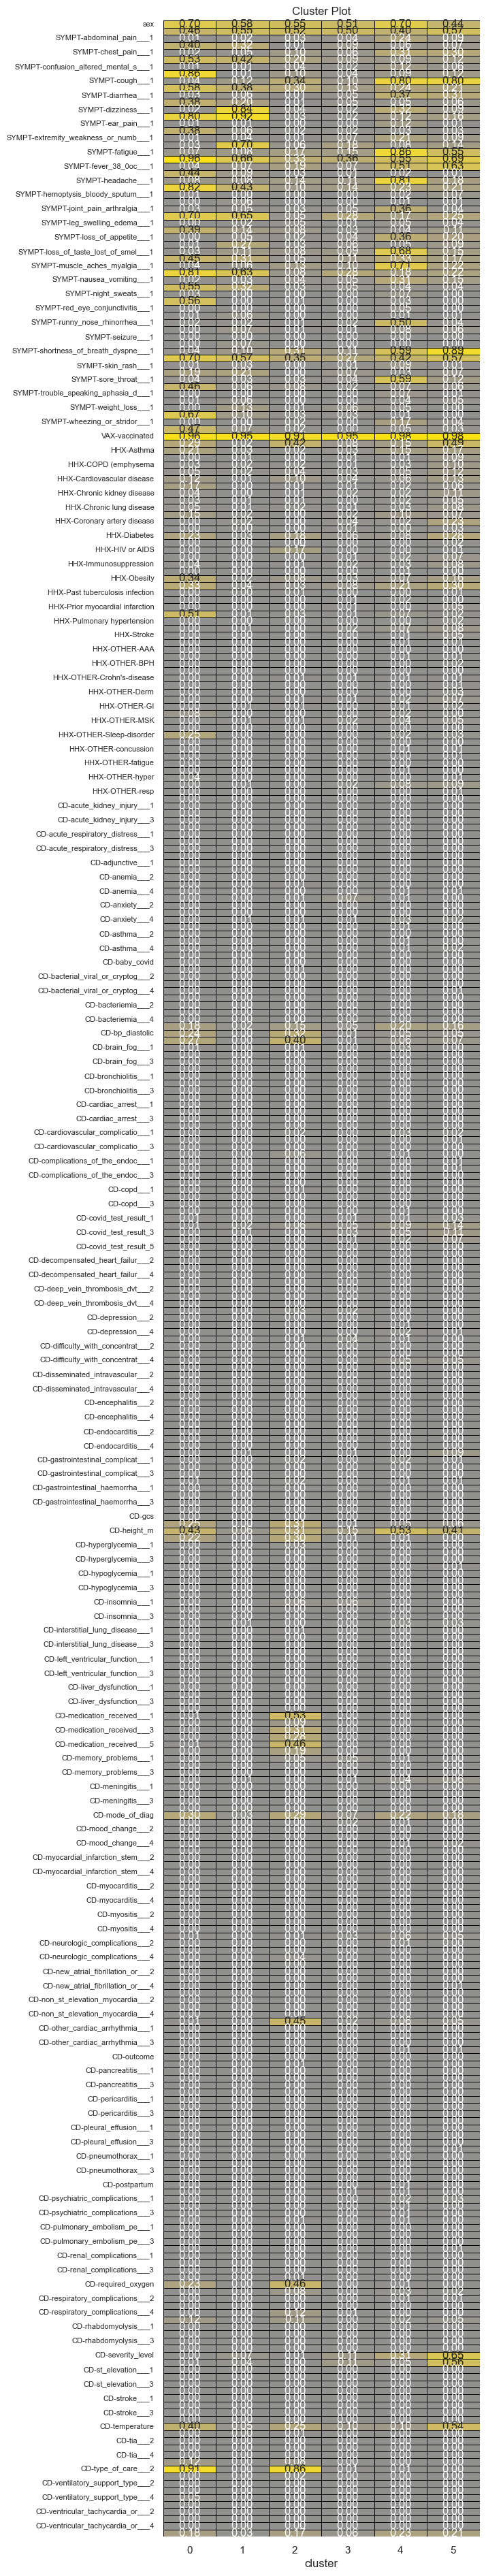

In [449]:
excursion_plot(A, method = "mean", style = "cont")

fn = f"mean-feature-values-umap-{tag}.png"
p = f"{figdir}/{fn}"

plt.savefig(p, dpi = 300, bbox_inches = 'tight')

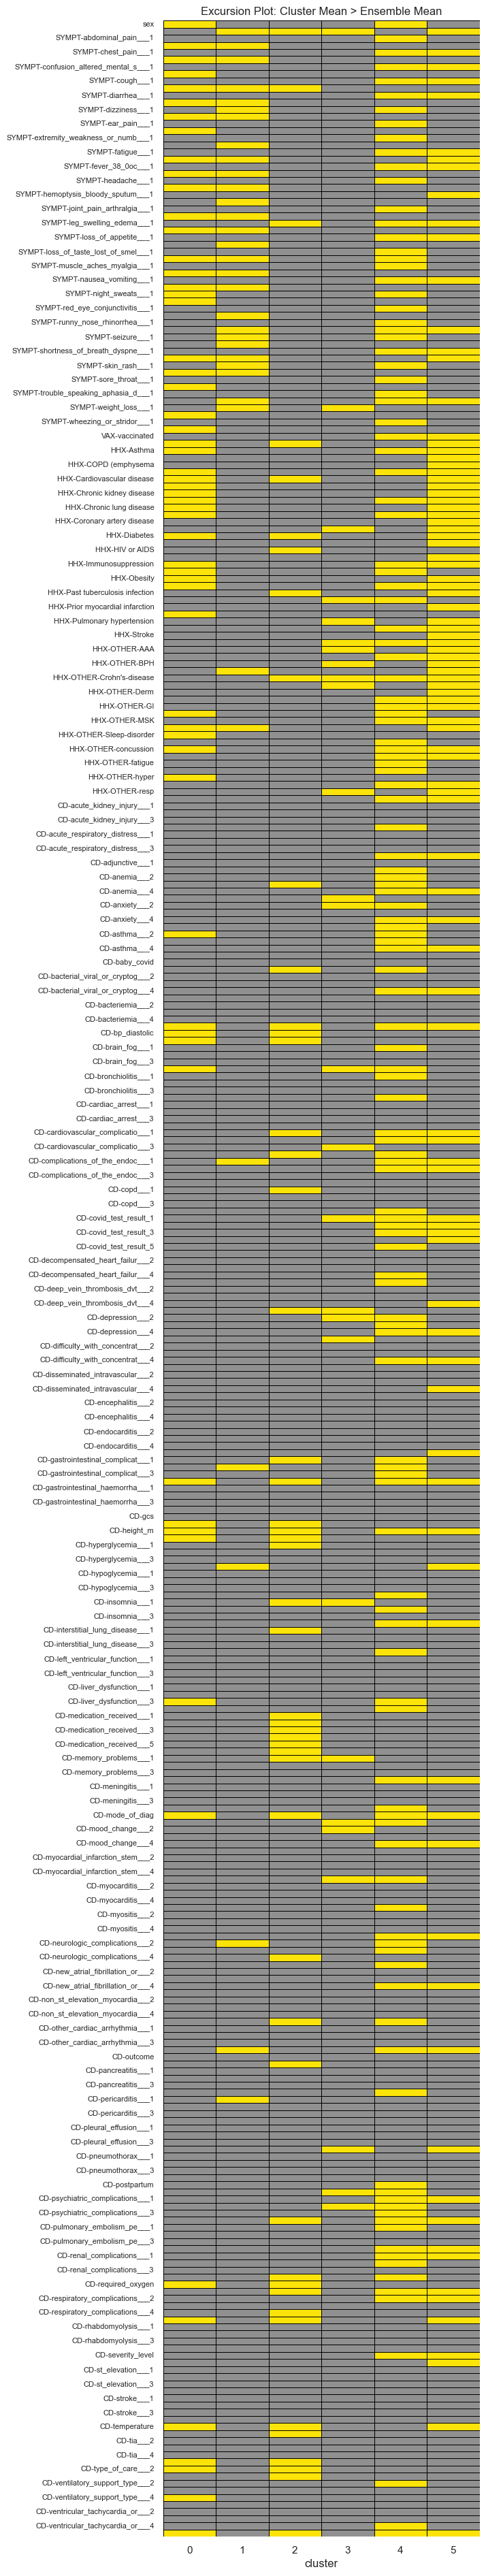

In [450]:
excursion_plot(A, method = "mean")


fn = f"binary-feature-values-umap-{tag}.png"
p = f"{figdir}/{fn}"

plt.savefig(p, dpi = 300, bbox_inches = 'tight')

### Compare some clusters

In [451]:
A["SITE"] = LC_pos_["SITE"]

In [452]:
ab = compare_two_clusters(A, 4,5)

ab.groupby("cluster")["SITE"].value_counts().unstack().fillna(0).astype(int)
ab


,sex,age,SYMPT-abdominal_pain___1,SYMPT-abdominal_pain___2,SYMPT-chest_pain___1,SYMPT-chest_pain___2,SYMPT-confusion_altered_mental_s___1,SYMPT-confusion_altered_mental_s___2,SYMPT-cough___1,SYMPT-cough___2,...,CD-ventilatory_support_type___2,CD-ventilatory_support_type___3,CD-ventilatory_support_type___4,CD-ventricular_tachycardia_or___1,CD-ventricular_tachycardia_or___2,CD-ventricular_tachycardia_or___3,CD-ventricular_tachycardia_or___4,CD-weight_kgs,cluster,SITE
0,1.0,0.207317,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,4,MTL
1,0.0,0.243902,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250245,4,MTL
2,1.0,0.280488,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.119682,4,MTL
3,1.0,0.451220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.184964,4,MTL
4,0.0,0.329268,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.560331,4,MTL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5570,1.0,0.365854,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.130563,5,LDN
5575,1.0,0.512195,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,5,LDN
5576,1.0,0.402439,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,5,LDN
5580,1.0,0.280488,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,5,LDN


In [453]:
ab.groupby("cluster")["HHX-HIV or AIDS"].value_counts(normalize = False).unstack().fillna(0)
pd.pivot_table(ab, index = ["cluster", "SITE"], values = "HHX-HIV or AIDS", aggfunc = "sum")
ab.groupby(["cluster", "SITE"])[["HHX-HIV or AIDS", "VAX-vaccinated"]].value_counts().unstack()

# interesting features
interesting = [
               # "VAX-vaccinated", 
                "HHX-HIV or AIDS", 
               "HHX-Diabetes", 
               "HHX-Arterial Hypertension", 
               "HHX-Psychiatric disease", 
            #    "age"
               ]


In [454]:
i2df = make_upset_data(ab, interesting)

/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'extra0': <Axes: ylabel='Count SITE'>}

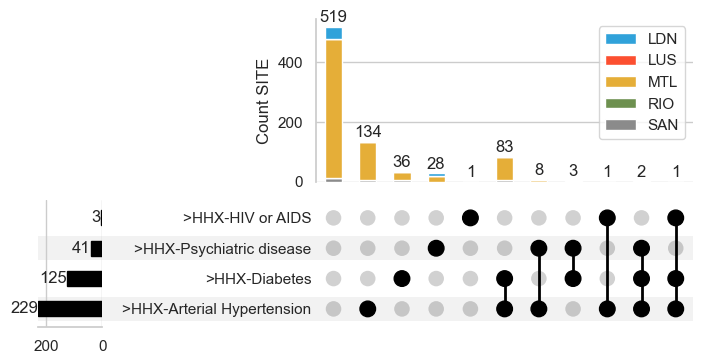

In [455]:
upset = UpSet(i2df, 
                subset_size = "count", 
                orientation = "horizontal", 
                show_counts = True, 
                intersection_plot_elements = 0
                )
upset.add_stacked_bars(by="SITE", title="Count SITE", elements=5, colors = cc.m_glasbey_hv)
# upset.add_stacked_bars(by="cluster", title="Count Cluster", elements=5, colors = cc.m_glasbey_hv)

upset.plot()

### UPSET PLOTS

In [456]:
II = pd.DataFrame(scaler.inverse_transform(A.drop(["cluster", "SITE"], axis = 1))) # type: ignore

# get column names and index names from X 
II.columns = X.columns
II.index   = X.index

II

,sex,age,SYMPT-abdominal_pain___1,SYMPT-abdominal_pain___2,SYMPT-chest_pain___1,SYMPT-chest_pain___2,SYMPT-confusion_altered_mental_s___1,SYMPT-confusion_altered_mental_s___2,SYMPT-cough___1,SYMPT-cough___2,...,CD-type_of_care___2,CD-ventilatory_support_type___1,CD-ventilatory_support_type___2,CD-ventilatory_support_type___3,CD-ventilatory_support_type___4,CD-ventricular_tachycardia_or___1,CD-ventricular_tachycardia_or___2,CD-ventricular_tachycardia_or___3,CD-ventricular_tachycardia_or___4,CD-weight_kgs
0,2.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.00
1,1.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.00
2,2.0,36.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.00
3,2.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.00
4,1.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,136.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5659,1.0,48.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93.38
5660,2.0,42.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,125.79
5661,1.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.24
5662,1.0,71.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,136.53


In [457]:
A.shape, X.shape, II.shape

((2014, 356), (2014, 354), (2014, 354))

In [458]:
# vv = A.drop("cluster", axis = 1)
B = II.copy()

# augment with site labels
B["SITE"] = LC_pos_["dag"].map(site_name_dict)

# expand the SITE column to five one-hot encoded columns
B = pd.concat([B, pd.get_dummies(B["SITE"])], axis = 1)

In [459]:
upset_A = make_upset_data(A, 
                       interesting, 
                       add_column = LC_pos_["dag"].map(site_name_dict)
                       )

In [460]:
upset_data = make_upset_data(B, 
                                interesting, 
                                keep_features = True)

indicators_bool = upset_data.select_dtypes(include = ['bool'])

In [461]:
# find all LABS cols in asas
ll = [c for c in upset_data.columns if c.startswith("LAB")]

/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

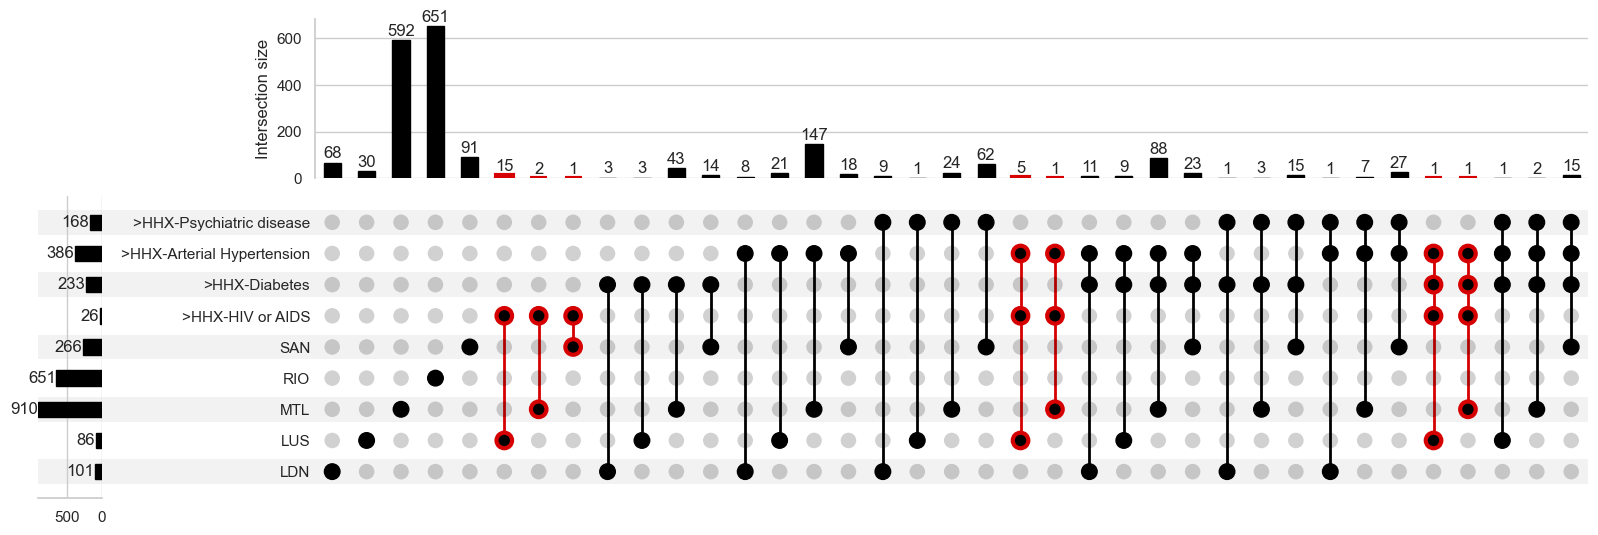

In [462]:
us = UpSet(
    from_indicators(indicators_bool, data = upset_data),
    # min_subset_size=15,
    # max_subset_size=200,
    show_counts                = True,
    sort_categories_by         = "input",
    subset_size                = "count",
    intersection_plot_elements = 5,
)

# us.add_stacked_bars(by="SITE", title="Count SITE", elements=5, colors = cc.m_glasbey_hv)

# TODO: if using catplots, make sure we invert the scaling transformation

# us.add_catplot(value = "LABS-haemoglobin", kind = "strip",elements=5, edgecolor='w', linewidth = 0.5, s = 5, alpha = 0.5, vmin = -100)
# us.add_catplot(value = "LABS-haemoglobin", kind = "box",elements=5)


us.style_subsets(present = ">HHX-HIV or AIDS",  edgecolor = cc.glasbey_light[0],  linewidth = 3, )


us.plot()
plt.show()

/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

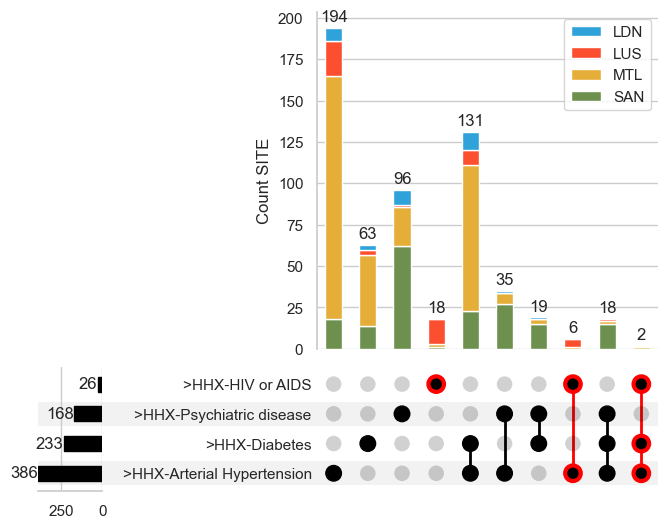

In [463]:
upset = UpSet(upset_A, 
                subset_size = "count", 
                orientation = "horizontal", 
                show_counts = True, 
                intersection_plot_elements = 0,
                max_subset_size = 200
                )
upset.style_subsets(present = ">HHX-HIV or AIDS",  edgecolor = "red", linewidth = 3)
# upset.style_subsets(present = [">HHX-HIV or AIDS", ">VAX-vaccinated"], edgecolor = "gold", linewidth = 3)
# upset.style_categories(">HHX-HIV or AIDS", shading_facecolor = "blue")
# upset.style_categories(">VAX-vaccinated", shading_facecolor = "green")

# upset.add_stacked_bars(by="cluster", title="Count Cluster", elements=10, colors = cc.m_glasbey_hv)
upset.add_stacked_bars(by="dag", title="Count SITE", elements=10, colors = cc.m_glasbey_hv, )


upset.plot()
plt.show()

# TODO

- "feature importances" - what features discriminate between the clusters?

# SUBGROUP: Lusaka

In [464]:
# make a df just for Lusaka
df_lusaka = LC_pos.query('dag == 5').copy()


In [465]:

# drop object columns
# drop columns with dtype = object
try:
    df_lusaka = df_lusaka.drop(columns=['LC_STATUS'])

except:
    pass

df_lusaka.info()


<class 'pandas.core.frame.DataFrame'>
Index: 86 entries, 3728 to 5620
Columns: 421 entries, sex to SITE
dtypes: float64(366), int64(54), object(1)
memory usage: 283.5+ KB


In [466]:
# fill nas with zero
# df_lusaka.fillna(0, inplace = True)
df_lusaka.dropna(inplace = True, axis = 1)

# drop SITE and dag
d1 = df_lusaka.drop(columns = ['SITE', 'dag'])

In [467]:
d1.shape, df_lusaka.shape

((86, 85), (86, 87))

In [468]:
# sklearn pipelines
import sklearn.cluster as cluster
from sklearn.pipeline import Pipeline

# instantiate the pipeline
hdb_parms['min_cluster_size'] = int(np.sqrt(d1.shape[0]))

pipe = Pipeline([
                ('scale', MinMaxScaler()),
                ('embed', UMAP(**umap_parms, verbose = True)),
                # ('embed', tsne_transformer),
                # ('cluster', cluster.HDBSCAN(min_cluster_size = min_cluster_size)),
                ('cluster', HDBSCAN(prediction_data = True)),

                ])

# apply to the lusaka dataframe
pipe.fit(d1)

# check the version of the embed object

if isinstance(pipe.steps[1][1], UMAP):
    points   = pipe["embed"].embedding_
elif isinstance(pipe.steps[1][1], FunctionTransformer):
    points   = pipe["embed"].transform(d1)
else:
    print(f"Something went wrong - {pipe.steps[1][1]}")

clusters = pipe["cluster"].labels_
probs    = pipe["cluster"].probabilities_
sites    = LC_pos_.loc[X.index]["dag"].map(site_name_dict)

# # cluster labels are the maximally probable cluster
cluster_labels = np.argmax(all_points_membership_vectors(pipe["cluster"]), 
                           axis = 1)

clusters = cluster_labels

# plot it
# sns.scatterplot(x = points[:,0], y = points[:,1], hue = clusters, palette = palette_dict, size = list(probs*100), linewidth = 0.5, edgecolor = 'black')

UMAP(random_state=42, spread=5.0, verbose=True)
Sat Apr 27 21:54:28 2024 Construct fuzzy simplicial set
Sat Apr 27 21:54:28 2024 Finding Nearest Neighbors
Sat Apr 27 21:54:28 2024 Finished Nearest Neighbor Search
Sat Apr 27 21:54:28 2024 Construct embedding


/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sat Apr 27 21:54:28 2024 Finished embedding


In [469]:
len(points)

86

In [470]:
plot_df = pd.DataFrame(points, columns = ["x", "y"], index = df_lusaka.index)
plot_df["Cluster"] = clusters
plot_df["Cluster Confidence"] = probs
plot_df["Site"] = df_lusaka["dag"].map(site_name_dict)

# what fraction of the data is in each cluster?
plot_df["Cluster"].value_counts(normalize = True)*100


Cluster
1    53.488372
0    46.511628
Name: proportion, dtype: float64

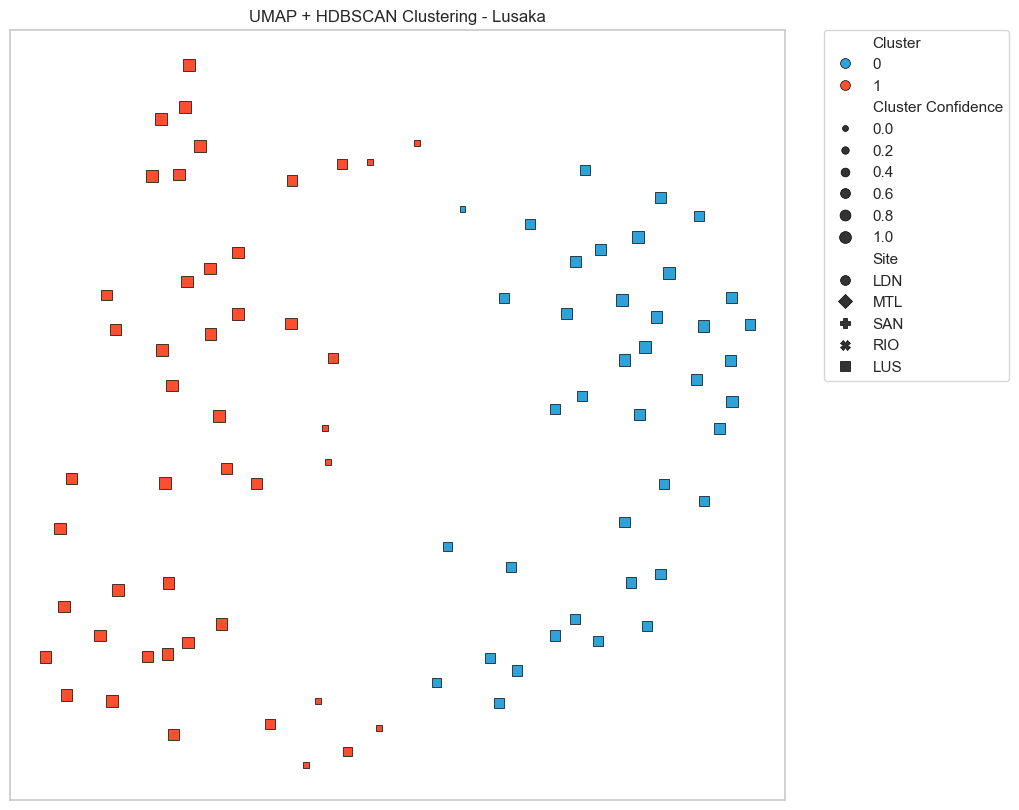

In [471]:
plot_clusters(plot_df, site_name_dict, title = f"UMAP + HDBSCAN Clustering - Lusaka")